In [226]:
import json
from pathlib import Path

TSV_PATH = Path("/Users/joregan/Playing/hsi/annotations/word_annotations/main")
JSON_PATH = Path("/Users/joregan/Playing/hsi/annotations/final_resolved")

In [227]:
old_json = {}
tsv_cache = {}

In [228]:
def slurp(filename):
    with open(filename) as f:
        segment = json.load(f)
    return segment

In [246]:
def get_topic_context(segment, size=None, keep_topic=True):
    rec_id = segment["recording_id"]
    orig_seg_id = segment["segment_id"]
    if not rec_id in old_json:
        with open(JSON_PATH / f"{rec_id}.json") as inf:
            old_json[rec_id] = json.load(inf)
    original = old_json[rec_id]
    orig_keys = list(original.keys())
    orig_keys.sort(key=lambda x: int(x))
    orig_topic = original[orig_seg_id]["high_level"]["current_topic"]

    index = orig_keys.index(orig_seg_id)
    if size is None:
        start = 0
    else:
        start = index - size
    ctx_range = orig_keys[start:index]

    if size is not None and len(ctx_range) < size:
        if int(orig_seg_id) <= size:
            pass
        else:
            print(f"Warning: size of {size} cannot be satisfied: {ctx_range}")
    
    topics = [original[x]["high_level"]["current_topic"] for x in ctx_range]

    tmp = []
    for p in zip(ctx_range, topics):
        if not keep_topic:
            tmp.append(original[p[0]]["snippet"])
        elif keep_topic and p[1] == orig_topic:
            tmp.append(original[p[0]]["snippet"])
        else:
            tmp.append(None)
    return " ".join([x for x in tmp if x is not None])

In [230]:
def get_time_context(segment, ctx_time = 5.0):
    rec_id = segment["recording_id"]
    start = segment["timing"]["utterance_start"]

    if not rec_id in tsv_cache:
        with open(TSV_PATH / f"{rec_id}_main.tsv") as inf:
            lines = []
            for line in inf.readlines():
                line = line.strip()
                if "\t" in line:
                    lines.append(line.split("\t"))
            tsv_cache[rec_id] = lines

    tsv_times = tsv_cache[rec_id]
    extract = []
    for time in tsv_times:
        s = float(time[0])
        e = float(time[1])
        if s >= (start - ctx_time) and (e < start):
            extract.append(time[2])
    return " ".join(extract)

In [ ]:
META_PATH = Path("/Users/joregan/Playing/hsi/annotations/meta")

for file in META_PATH.glob("*.json"):
    seg = slurp(str(file))
    txt_ctx = get_topic_context(seg, 5)
    aud_ctx = get_time_context(seg, 20.0)

    print("TEXT", txt_ctx)
    print("AUDIO", aud_ctx)
    print("UTTERANCE", seg["utterance"])
    print()

In [ ]:
# totally unrelated code to extract a list of tuples from a vlm
def get_answer(text):
    flat = text.replace(" ", "")
    if ")]" in flat:
        return eval(flat[flat.find("[("):flat.rfind(")]")+2])
    else:
        return eval(flat[flat.find("[("):flat.rfind(")")+1] + "]")

In [262]:
def get_answer(text):
    flat = text.replace(" ", "")
    if "]]" in flat:
        return eval(flat[flat.find("[["):flat.rfind("]]")+2])
    else:
        return eval(flat[flat.find("[["):flat.rfind("]")+1] + "]")

In [264]:
get_answer("asdasd  a [[4, 2,4,4]]  a")

[[4, 2, 4, 4]]

In [270]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_bounding_box(image_path, bbox, title="Bounding Box"):
    """
    Display an image with a bounding box overlay.

    Parameters:
        image_path (str): Path to the image file.
        bbox (list): Bounding box in the format [x_min, y_min, x_max, y_max].
        title (str): Title for the plot.
    """
    # Load the image
    img = Image.open(image_path)
    x1, y1, x2, y2 = bbox

    # Create the plot
    fig, ax = plt.subplots()
    ax.imshow(img)
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.set_title(title)
    plt.axis('on')
    plt.show()

# Example usage:
# show_bounding_box("hsi_3_0715_210_010_41_color.png", [370, 310, 630, 395], title="Sofa Bounding Box")


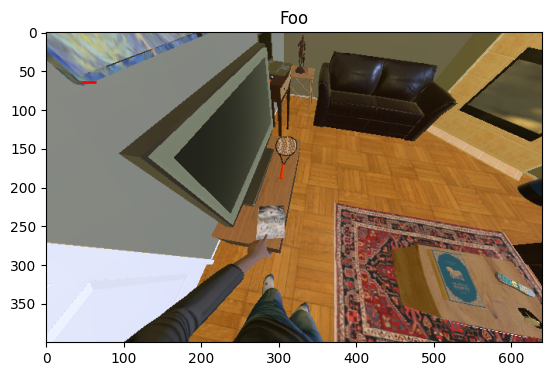

In [ ]:
show_bounding_box("/tmp/color/hsi_5_0718_222_002_49_000_depth.png", [44, 64, 64, 64], title="Foo")